Index(['height', 'outflow', 'pump1_rpm', 'pump1_power', 'pump4_rpm',
       'pump4_power'],
      dtype='object')


<bound method Figure.show of <Figure size 640x480 with 2 Axes>>

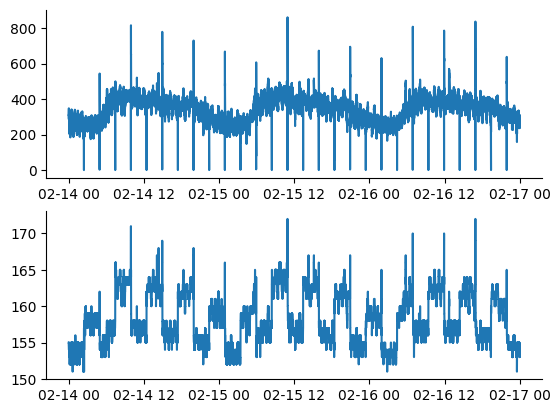

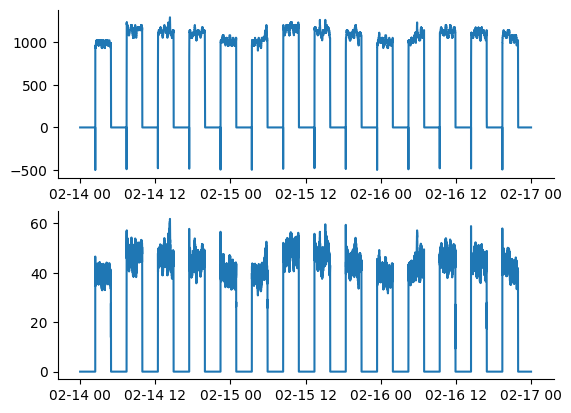

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_parquet('Data/pump_station_data.parquet')
data = data[:]["2023-02-14":"2023-02-16"]
data.to_csv("pump_data_14_02_to_16_02")
print(data.columns)
fig, ax = plt.subplots(2)
ax[0].plot(data['outflow'])
ax[1].plot(data['height'])
fig.show
fig, ax = plt.subplots(2)
ax[0].plot(data['pump1_rpm'])
ax[1].plot(data['pump1_power'])
fig.show

# Building a static model of the 


In [15]:
import sklearn.model_selection as modsel

data_train, data_test = modsel.train_test_split(data, test_size=0.2, shuffle=False)


In [16]:
# Format the data so that it can be used to fit the ARX model
# The rpm values of both pumps are chosen as input values
x_train = data_train.drop(labels=['height','outflow', 'pump1_rpm', 'pump4_rpm'], axis=1)
x_train = x_train.to_numpy()
y_train = data_train['outflow'].values.reshape(-1,1)

x_test = data_test.drop(labels=['height','outflow', 'pump1_rpm', 'pump4_rpm'], axis=1)
print(x_test)
x_test = x_test.to_numpy()
y_test = data_test['outflow'].values.reshape(-1,1)

                                  pump1_power  pump4_power
time                                                      
2023-02-16 09:36:00.342000+00:00        46.75         0.00
2023-02-16 09:36:01.342000+00:00        48.31         0.00
2023-02-16 09:36:02.342000+00:00        47.72         0.00
2023-02-16 09:36:03.342000+00:00        49.06         0.00
2023-02-16 09:36:04.342000+00:00        47.51         0.00
...                                       ...          ...
2023-02-16 23:59:55.342000+00:00         0.00        33.04
2023-02-16 23:59:56.342000+00:00         0.00        34.25
2023-02-16 23:59:57.342000+00:00         0.00        35.03
2023-02-16 23:59:58.342000+00:00         0.00        34.87
2023-02-16 23:59:59.342000+00:00         0.00        33.61

[51840 rows x 2 columns]


In [17]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)

In [18]:

# The model is fitted 
basis_function= Polynomial(degree=1)
rrse_low = 1
i_j_a_h_best = []
yhat_best = []
model = FROLS(
    order_selection=True,
    n_terms = 6,
    extended_least_squares=False,
    ylag=1,
    xlag=[[1, 17],[1,17]],
    info_criteria="aic",
    estimator="least_squares",
    basis_function=basis_function,
    )
model.fit(X=x_train, y=y_train)
yhat = model.predict(X=x_test,y=y_test)
rrse = root_relative_squared_error(y_test, yhat)

                                
                                
                                   

    

/home/martin/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)
/home/martin/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/model_structure_selection/forward_regression_orthogonal_least_squares.py:569: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6
  self.info_values = self.information_criterion(reg_matrix, y)


In [19]:
print(i_j_a_h_best)
print(rrse)

[]
0.48049884494233336


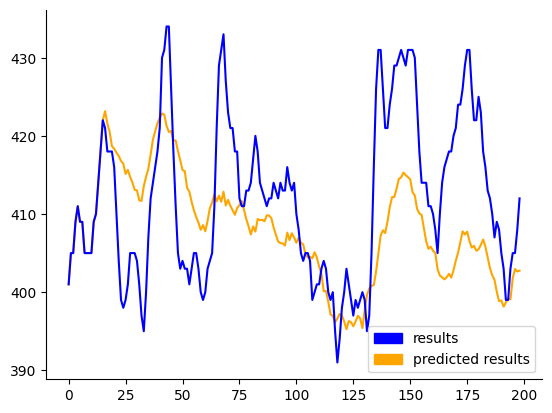

In [20]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots()
ax.plot(yhat[1:200], color='orange')
ax.plot(y_test[1:200], color='blue')
orange_patch = mpatches.Patch(color='orange', label='predicted results')
blue_patch = mpatches.Patch(color='blue', label='results')
ax.legend(handles=[blue_patch,orange_patch])

plt.show()

In [21]:
r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

  Regressors   Parameters             ERR
0     y(k-1)   9.8685E-01  9.99888384E-01
1          1  -4.2814E+00  7.03943391E-08
2    x2(k-1)   6.8818E-01  2.21073881E-08
3   x2(k-17)  -4.6099E-01  6.67136503E-06
4    x1(k-1)   5.4238E-01  3.21397794E-06
5   x1(k-17)  -3.4074E-01  2.47062974E-06


In [22]:
from sklearn.linear_model import BayesianRidge
from sysidentpy.general_estimators import NARX
from sysidentpy.basis_function._basis_function import Polynomial
basis_function= Polynomial(degree=1)
rrse_low = 1
i_j_a_best = []
yhat_best = []

BayesianRidge_narx = NARX(
base_estimator=BayesianRidge(),
xlag=[[1, 14],[1,14],[1,14]],
ylag=3,
basis_function=basis_function,
model_type="NARMAX",
)

BayesianRidge_narx.fit(X=x_train, y=y_train)
yhat = BayesianRidge_narx.predict(X=x_test,y=y_test)
rrse_narx= root_relative_squared_error(y_test, yhat)
print(rrse_narx)
                                

                




0.48300259410060137


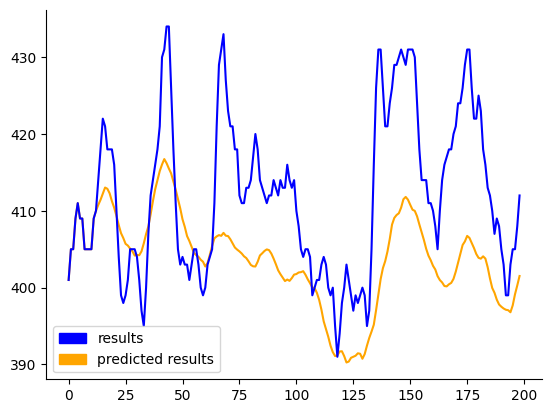

In [23]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots()
ax.plot(yhat[1:200], color='orange')
ax.plot(y_test[1:200], color='blue')
orange_patch = mpatches.Patch(color='orange', label='predicted results')
blue_patch = mpatches.Patch(color='blue', label='results')
ax.legend(handles=[blue_patch,orange_patch])

plt.show()


In [24]:
print(i_j_a_best)
print(rrse_low)

[]
1


In [25]:
from torch import nn
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.neural_network import NARXNN

from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.narmax_tools import regressor_code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu" 
print(f"Using {device} device")

torch.manual_seed(0)

Using cpu device


In [26]:
'''# build a neural network for the multiple input data
basis_function = Polynomial(degree=1)
eval_dict={}
rrse_low = 1
i_best = 0
yhat_best = []
       
for a in ['RReLU']:
    narx_net = NARXNN(
            ylag=1,
            xlag= [[1,11],[1,11]],
            basis_function=basis_function,
            model_type="NARMAX",
            loss_func="mse_loss",
            optimizer="Adam",
            epochs=5000,
            device='cuda',
            learning_rate = 4e-3,
            verbose=False,
            optim_params={
                "betas": (0.9, 0.999),
                "eps": 1e-05,
            }, 
        )
    class NARX(nn.Module):
                def __init__(self):
                    super().__init__()
                    self.lin = nn.Linear(13, 30)
                    self.lin2 = nn.Linear(30, 64)
                    self.lin3 = nn.Linear(64, 64)
                    self.lin4 = nn.Linear(64, 64)
                    self.lin5 = nn.Linear(64, 30)              
                    self.lin6 = nn.Linear(30, 1)
                    self.tanh = eval("nn."+a+"()")
                    

                def forward(self, xb):
                    print(xb.size)
                    print(type(xb))
                    xb = xb.reshape(-1,13)
                    z = self.lin(xb)
                    z = self.tanh(z)
                    z = self.lin2(z)
                    z = self.tanh(z)
                    z = self.lin3(z)
                    z = self.tanh(z)
                    z = self.lin4(z)
                    z = self.tanh(z)
                    z = self.lin5(z)
                    z = self.tanh(z)
                    z = self.lin6(z)
                    z = self.tanh(z)
                    
                    return z
    narx_net.net = NARX()
    if device == "cuda": 
        narx_net.net.to(torch.device("cuda"))
    # Train the model on the chosen test slot and the test data which is the last 20% of the train time slot
    narx_net.fit(X=x_train, y=y_train, X_test=x_test, y_test=y_test)
    # Predict the values with the created model and compare them to the actual values from the time slot one hour after the training time slot
    yhat = narx_net.predict(X=x_test, y=y_test, forecast_horizon=100)
    # Calculate the error of the model compared to the testing time slot
    mse = mean_squared_error(y_test, yhat)
    print("MSE: ", mse)
    rrse = root_relative_squared_error(y_test, yhat)
    print("RRSE: ",rrse)   '''

'# build a neural network for the multiple input data\nbasis_function = Polynomial(degree=1)\neval_dict={}\nrrse_low = 1\ni_best = 0\nyhat_best = []\n       \nfor a in [\'RReLU\']:\n    narx_net = NARXNN(\n            ylag=1,\n            xlag= [[1,11],[1,11]],\n            basis_function=basis_function,\n            model_type="NARMAX",\n            loss_func="mse_loss",\n            optimizer="Adam",\n            epochs=5000,\n            device=\'cuda\',\n            learning_rate = 4e-3,\n            verbose=False,\n            optim_params={\n                "betas": (0.9, 0.999),\n                "eps": 1e-05,\n            }, \n        )\n    class NARX(nn.Module):\n                def __init__(self):\n                    super().__init__()\n                    self.lin = nn.Linear(13, 30)\n                    self.lin2 = nn.Linear(30, 64)\n                    self.lin3 = nn.Linear(64, 64)\n                    self.lin4 = nn.Linear(64, 64)\n                    self.lin5 = nn.Line

In [27]:
# basis_function = Polynomial(degree=1)
# rrse_low = 1
# yhat_best = []

# narx_net = NARXNN(
#         ylag=2,
#         xlag=[[5], [5]],
#         basis_function=basis_function,
#         model_type="NARMAX",
#         loss_func="mse_loss",
#         optimizer="Adam",
#         epochs=100,
#         learning_rate = 4e-3,
#         verbose=False,
#         device='cuda',
#         optim_params={
#             "betas": (0.9, 0.999),
#             "eps": 1e-05,
#         }, 
#     )
# class NARX(nn.Module):
#         def __init__(self):
#             super().__init__()
#             self.lin = nn.Linear(4, 30)
#             self.lin2 = nn.Linear(30, 30)
#             self.lin3 = nn.Linear(30, 1)
#             self.tanh = nn.Tanh()

#         def forward(self, xb):
#             z = self.lin(xb)
#             z = self.tanh(z)
#             z = self.lin2(z)
#             z = self.tanh(z)
#             z = self.lin3(z)
#             return z
# narx_net.net = NARX()
# if device == "cuda": 
#     narx_net.net.to(torch.device("cuda"))
# narx_net.fit(X=x_train, y=y_train,X_test=x_test, y_test=y_test)
# yhat_best = narx_net.predict(X=x_test, y=y_test)
# print("MSE: ", mean_squared_error(y_test, yhat))
# rrse = root_relative_squared_error(y_, yhat)
# print("RRSE: ",rrse)
    
   
                                


In [28]:
# print("MSE: ", mean_squared_error(y_test, yhat_best))
# rrse = root_relative_squared_error(y_test, yhat_best)
# print("RRSE: ",rrse)
    


In [29]:
""" 
import matplotlib.patches as mpatches
fig, ax = plt.subplots()
ax.plot(yhat_best, color='orange')
ax.plot(y_test, color='blue')
orange_patch = mpatches.Patch(color='orange', label='predicted results')
blue_patch = mpatches.Patch(color='blue', label='results')
ax.legend(handles=[blue_patch,orange_patch])

plt.show()
 """

" \nimport matplotlib.patches as mpatches\nfig, ax = plt.subplots()\nax.plot(yhat_best, color='orange')\nax.plot(y_test, color='blue')\norange_patch = mpatches.Patch(color='orange', label='predicted results')\nblue_patch = mpatches.Patch(color='blue', label='results')\nax.legend(handles=[blue_patch,orange_patch])\n\nplt.show()\n "

In [30]:
import sklearn.model_selection as modsel    
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_data = data['2023-02-14 12:27:00':'2023-02-14 14:50:00'].resample("1min").mean()

train_data = train_data.drop(labels=['height', 'pump1_power','pump4_power', 'pump4_rpm'], axis=1)
train_data = train_data.reset_index(drop=True)

scaled_data = scaler.fit_transform(train_data)

train_data = pd.DataFrame(scaled_data,columns=train_data.columns, index=train_data.index)
data_train, data_test = modsel.train_test_split(train_data, test_size=0.2, shuffle=False)

x_train_1 = data_train['pump1_rpm'].values.reshape(-1,1)


y_train_1 = data_train['outflow'].values.reshape(-1,1)

# Format the data so that it can be used to fit the ARX model
# The rpm values of both pumps are chosen as input values
x_test_1 = data_test['pump1_rpm'].values.reshape(-1,1)
y_test_1 = data_test['outflow'].values.reshape(-1,1)


In [31]:
train_data.index

RangeIndex(start=0, stop=144, step=1)

In [32]:
from torch import nn
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.neural_network import NARXNN

from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.narmax_tools import regressor_code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu" 
print(f"Using {device} device")

Using cpu device


In [33]:
basis_function = Polynomial(degree=1)
eval_dict={}
rrse_low = 1
i_best = 0
yhat_best = []
for i in ['RReLU']:
    narx_net = NARXNN(
            ylag=2,
            xlag= 3,
            basis_function=basis_function,
            model_type="NARMAX",
            loss_func="mse_loss",
            optimizer="Adam",
            epochs=2000,
            device='cuda',
            learning_rate = 4e-3,
            verbose=False,
            optim_params={
                "betas": (0.9, 0.999),
                "eps": 1e-05,
            }, 
        )
    class NARX(nn.Module):
                def __init__(self):
                    super().__init__()
                    self.lin = nn.Linear(5, 30)
                    self.lin2 = nn.Linear(30, 64)
                    self.lin3 = nn.Linear(64, 64)
                    self.lin4 = nn.Linear(64, 30)               
                    self.lin5 = nn.Linear(30, 1)
                    self.tanh = eval("nn."+i+"()")
                    

                def forward(self, xb):
                    z = self.lin(xb)
                    z = self.tanh(z)
                    z = self.lin2(z)
                    z = self.tanh(z)
                    z = self.lin3(z)
                    z = self.tanh(z)
                    z = self.lin4(z)
                    z = self.tanh(z)
                    z = self.lin5(z)
                    z = self.tanh(z)
                    
                    return z
    narx_net.net = NARX()
    if device == "cuda": 
        narx_net.net.to(torch.device("cuda"))
    narx_net.fit(X=x_train_1, y=y_train_1,X_test=x_test_1, y_test=y_test_1)
    yhat = narx_net.predict(X=x_test_1, y=y_test_1)
    mse = mean_squared_error(y_test_1, yhat)
    print("MSE: ", mse)
    rrse = root_relative_squared_error(y_test_1, yhat)
    print("RRSE: ",rrse)   
    eval_dict.update({i:{"rrse":rrse,"mse":mse,'yhat':yhat}})
   

/home/martin/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/neural_network/narx_nn.py:156: UserWarning: No CUDA available. We set the device as CPU
  self.device = self._check_cuda(device)


MSE:  0.14167475070867908
RRSE:  0.5348321455117835


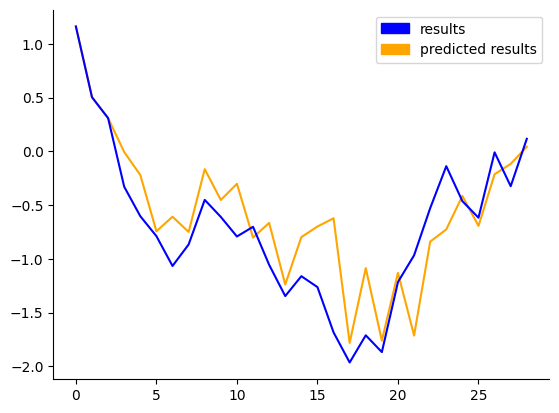

In [34]:

import matplotlib.patches as mpatches
fig, ax = plt.subplots()
ax.plot(eval_dict["RReLU"]['yhat'], color='orange')
ax.plot(y_test_1, color='blue')
orange_patch = mpatches.Patch(color='orange', label='predicted results')
blue_patch = mpatches.Patch(color='blue', label='results')
ax.legend(handles=[blue_patch,orange_patch])

plt.show()

In [50]:
import sklearn.model_selection as modsel    
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Get a data sample from the dataset in which pump 4 is running and resample 
# it to reduce the training time of the model

train_data = data['2023-02-14 10:00:00':'2023-02-14 11:20:00'].resample("10s").mean()


train_data = train_data.drop(labels=['height', 'pump1_power','pump4_power', 'pump1_rpm'], axis=1)
train_data = train_data.reset_index(drop=True)
scaled_data = scaler.fit_transform(train_data)


# Split the data into train and test data for the model training
train_data = pd.DataFrame(scaled_data,columns=train_data.columns, index=train_data.index)
data_train, data_test = modsel.train_test_split(train_data, test_size=0.2, shuffle=False)

# Format the data so that it can be used for training the model
x_train_4 = data_train['pump4_rpm'].values.reshape(-1,1)
y_train_4 = data_train['outflow'].values.reshape(-1,1)


# Format the data so that it can be used to fit the neural network
x_test_4 = data_test['pump4_rpm'].values.reshape(-1,1)
y_test_4 = data_test['outflow'].values.reshape(-1,1)

# Get test data for the model comparison after training 
# This data is taken just after the data used for training
test_data = data['2023-02-14 11:20:00':'2023-02-14 12:20:00'].resample("10s").mean()
test_data = test_data.drop(labels=['height', 'pump1_power','pump4_power', 'pump1_rpm'], axis=1)
test_data = test_data.reset_index(drop=True)
scaled_test_data = scaler.fit_transform(test_data)
test_data = pd.DataFrame(scaled_test_data,columns=test_data.columns, index=test_data.index)

#Format the data so that it can be used with the toolbox
x_test_compare_4 = test_data['pump4_rpm'].values.reshape(-1,1)
y_test_compare_4 = test_data['outflow'].values.reshape(-1,1)

# Get compare data from a day later to validate the model
compare_data = data['2023-02-15 11:00:00':'2023-02-15 13:00:00'].resample("10s").mean()

compare_data = compare_data.drop(labels=['height', 'pump1_power','pump4_power', 'pump1_rpm'], axis=1)
compare_data = compare_data.reset_index(drop=True)
scaled_compare_data = scaler.fit_transform(compare_data)
compare_data = pd.DataFrame(scaled_compare_data,columns=compare_data.columns, index=compare_data.index)
# X and Y values for the validation of the created model
x_compare_4 = compare_data['pump4_rpm'].values.reshape(-1,1)
y_compare_4 = compare_data['outflow'].values.reshape(-1,1)


In [51]:
from torch import nn
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.neural_network import NARXNN

from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.narmax_tools import regressor_code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu" 
print(f"Using {device} device")

Using cpu device


In [52]:
basis_function = Polynomial(degree=1)
eval_dict={}
rrse_low = 1
i_best = 0
yhat_best = []
for a in ['RReLU']:
            narx_net = NARXNN(
                    ylag=3,
                    xlag= 11,
                    basis_function=basis_function,
                    model_type="NARMAX",
                    loss_func="mse_loss",
                    optimizer="Adam",
                    epochs=5000,
                    device='cuda',
                    learning_rate = 4e-3,
                    verbose=False,
                    optim_params={
                        "betas": (0.9, 0.999),
                        "eps": 1e-05,
                    }, 
                )
            class NARX(nn.Module):
                        def __init__(self):
                            super().__init__()
                            self.lin = nn.Linear((14), 30)
                            self.lin2 = nn.Linear(30, 64)
                            self.lin3 = nn.Linear(64, 64)
                            self.lin4 = nn.Linear(64, 64)
                            self.lin5 = nn.Linear(64, 30)               
                            self.lin6 = nn.Linear(30, 1)
                            self.tanh = eval("nn."+a+"()")
                            

                        def forward(self, xb):
                            z = self.lin(xb)
                            z = self.tanh(z)
                            z = self.lin2(z)
                            z = self.tanh(z)
                            z = self.lin3(z)
                            z = self.tanh(z)
                            z = self.lin4(z)
                            z = self.tanh(z)
                            z = self.lin5(z)
                            z = self.tanh(z)
                            z = self.lin6(z)
                            z = self.tanh(z)
                            
                            return z
            narx_net.net = NARX()
            if device == "cuda": 
                narx_net.net.to(torch.device("cuda"))
            # Train the model on the chosen test slot and the test data which is the last 20% of the train time slot
            narx_net.fit(X=x_train_4, y=y_train_4, X_test=x_test_4, y_test=y_test_4)
            # Predict the values with the created model and compare them to the actual values from the time slot one hour after the training time slot
            yhat = narx_net.predict(X=x_test_compare_4, y=y_test_compare_4)
            # Calculate the error of the model compared to the testing time slot
            mse = mean_squared_error(y_test_compare_4, yhat)
            print("MSE: ", mse)
            rrse = root_relative_squared_error(y_test_compare_4, yhat)
            print("RRSE: ",rrse)   

        





        
   

/home/martin/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/neural_network/narx_nn.py:156: UserWarning: No CUDA available. We set the device as CPU
  self.device = self._check_cuda(device)


MSE:  0.26126375321441125
RRSE:  0.511139661163572


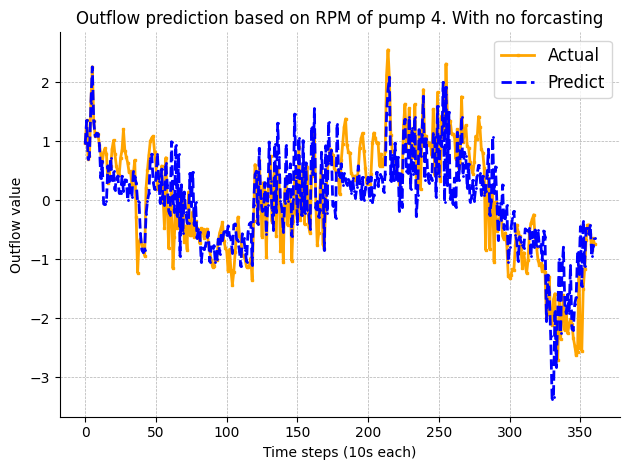

In [49]:

import matplotlib.patches as mpatches
fig, ax = plt.subplots()
ax.plot(y_test_compare_4, color='orange', linestyle='-', linewidth=2, marker='s', markersize=1.5, label='Actual')
ax.plot(yhat ,color='blue', linestyle='--', linewidth=2, marker='o', markersize=1, label='Predict')

ax.set_title(f"Outflow prediction based on RPM of pump 4. With no forcasting")
ax.set_xlabel(f"Time steps (10s each)")
ax.set_ylabel("Outflow value")
ax.grid(True, which='both', linestyle='--', linewidth = 0.5)

# Adding a legend
plt.legend(fontsize=12)

# Adjusting the layout
plt.tight_layout()

plt.show()
plt.savefig()

[[ 0.96606594]
 [ 1.3539532 ]
 [ 0.7035564 ]
 [ 0.746655  ]
 [ 1.6517252 ]
 [ 2.2629416 ]
 [ 1.338281  ]
 [ 1.0914437 ]
 [ 1.1384603 ]
 [ 1.1227881 ]
 [ 0.9464757 ]
 [ 0.8261718 ]
 [ 0.6638404 ]
 [ 0.65812075]
 [ 0.58896434]
 [ 0.40048808]
 [ 0.2221496 ]
 [ 0.3592685 ]
 [ 0.3927254 ]
 [ 0.38633704]
 [ 0.30246916]
 [ 0.26390716]
 [ 0.2960181 ]
 [ 0.32418033]
 [ 0.32253036]
 [ 0.36254382]
 [ 0.2817745 ]
 [ 0.2766639 ]
 [ 0.30427542]
 [ 0.3777271 ]
 [ 0.3303257 ]
 [ 0.36205205]
 [ 0.29046047]
 [ 0.20188285]
 [ 0.2657012 ]
 [ 0.3700549 ]
 [ 0.37426925]
 [-0.3525898 ]
 [-0.13517456]
 [-0.29266822]
 [-0.40318155]
 [-0.31947356]
 [-0.86964643]
 [-0.02835612]
 [-0.15282625]
 [-0.03727438]
 [ 0.41373464]
 [ 1.148393  ]
 [ 1.1207299 ]
 [ 0.7896464 ]
 [ 0.49729133]
 [ 0.6212954 ]
 [ 0.12045167]
 [-0.00639408]
 [ 0.46118236]
 [ 0.3795214 ]
 [-0.25420025]
 [ 0.42273182]
 [-0.04910808]
 [-0.19341953]
 [-0.14254248]
 [ 1.0167795 ]
 [-0.35667306]
 [-0.06949595]
 [ 0.54908997]
 [-0.6405146 ]
 [-0.09919

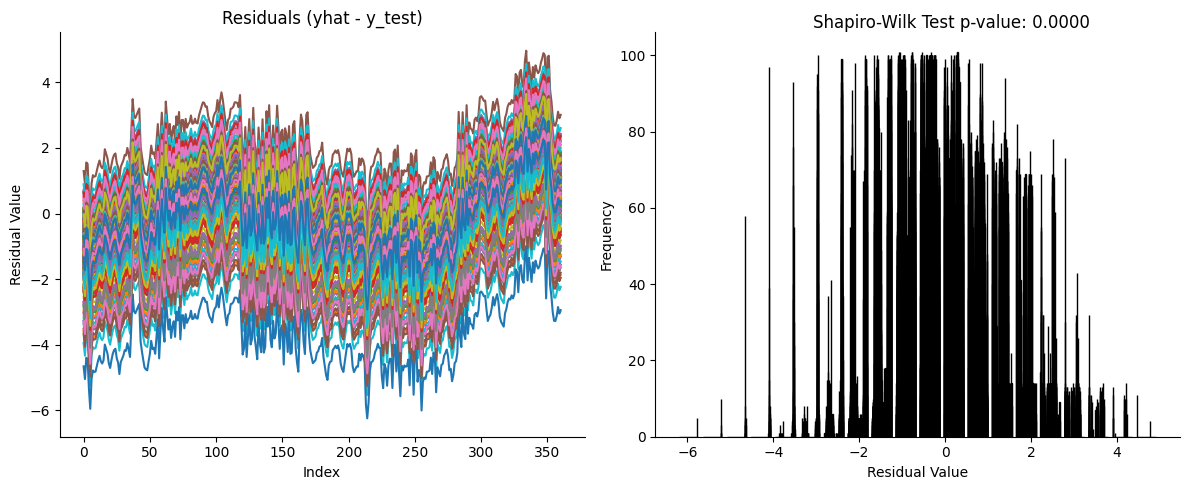

Shapiro-Wilk Test result:
Statistic: 0.9986, p-value: 0.0000


In [64]:
from scipy.stats import shapiro


residuals = yhat.squeeze() - y_test_compare_4
print(yhat)
#print(y_test_compare_4)
print(yhat.squeeze())


# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Plot of residuals
axs[0].plot(residuals)
axs[0].set_title('Residuals (yhat - y_test)')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Residual Value')

# Second subplot: Histogram of residuals
axs[1].hist(residuals, bins=20, edgecolor='black')
axs[1].set_xlabel('Residual Value')
axs[1].set_ylabel('Frequency')
print(residuals.size)
# Perform Shapiro-Wilk Test for normality
stat, p = shapiro(residuals)
axs[1].annotate(f'Shapiro-Wilk Test p-value: {p:.4f}', xy=(0.3, 1.01), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.show()

# Print Shapiro-Wilk Test result
print("Shapiro-Wilk Test result:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")

MSE:  0.22511154523782637
RRSE:  0.4744592134607846


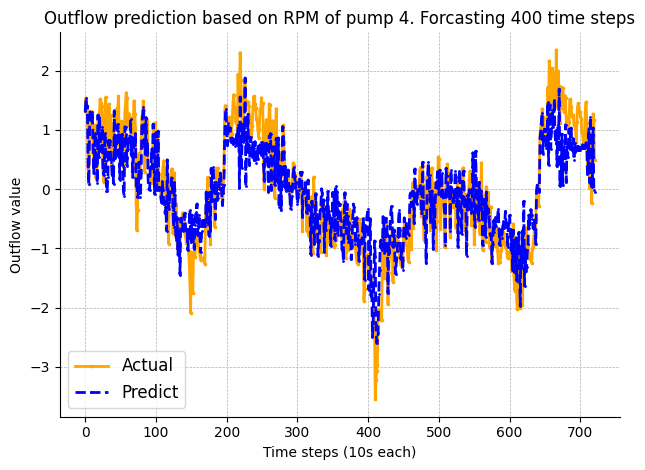

In [46]:
yhat = narx_net.predict(X=x_compare_4, y=y_compare_4, forecast_horizon=400)
# Calculate the error of the model compared to the testing time slot
mse = mean_squared_error(y_compare_4, yhat)
print("MSE: ", mse)
rrse = root_relative_squared_error(y_compare_4, yhat)
print("RRSE: ",rrse)   

fig, ax = plt.subplots()
ax.plot(y_compare_4, color='orange', linestyle='-', linewidth=2, marker='s', markersize=1.5, label='Actual')
ax.plot(yhat ,color='blue', linestyle='--', linewidth=2, marker='o', markersize=1, label='Predict')

ax.set_title(f"Outflow prediction based on RPM of pump 4. Forcasting of 400 time steps")
ax.set_xlabel(f"Time steps (10s each)")
ax.set_ylabel("Outflow value")
ax.grid(True, which='both', linestyle='--', linewidth = 0.5)

# Adding a legend
plt.legend(fontsize=12)

# Adjusting the layout
plt.tight_layout()
# orange_patch = mpatches.Patch(color='orange', label='predicted results')
# blue_patch = mpatches.Patch(color='blue', label='results')
# ax.legend(handles=[blue_patch,orange_patch])

plt.show()